# Fashion MNIST

Test

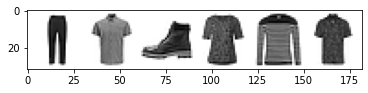

Trouser  Shirt   Boot    Top Pullover  Shirt


In [1]:
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from matplotlib import pyplot

# Import the Fashion-MNIST dataset
transform = transforms.ToTensor()

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=6, shuffle=True, num_workers=4)

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=4)

# Name the classes
classes = (
    'Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Boot'
)

# Show six random images and their corresponding classes
images, labels = iter(trainloader).next()
img = utils.make_grid(images)
pyplot.imshow((1 - img).numpy().transpose((1, 2, 0)))
pyplot.show()
print(' '.join('%6s' % classes[label] for label in labels))

In [2]:
from torch import no_grad, empty
from torch.nn import Module, Linear, Conv2d, MaxPool2d
from torch.nn.functional import relu
from blitz.utils import variational_estimator
from blitz.modules import BayesianLinear, BayesianConv2d

# Create the classical CNN class
class ClassicalCNN(Module):
    def __init__(self):
        # Define the functions used in the layers
        super(ClassicalCNN, self).__init__()
        self.conv1 = Conv2d(1, 6, 5)
        self.pool = MaxPool2d(2, 2)
        self.conv2 = Conv2d(6, 16, 3)
        self.fc1 = Linear(16 * 5 * 5, 160)
        self.fc2 = Linear(160, 120)
        self.fc3 = Linear(120, 84)
        self.fc4 = Linear(84, 10)

    def forward(self, x):
        # One forward calculation
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def accuracy(self, loader):
        # Calculate the accuracy for a given set
        correct = 0
        total = 0
        with no_grad():
            for _, (images, labels) in enumerate(loader):
                outputs = self(images)
                predicted = outputs.argmax(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

# Creat an instance of the classical CNN
classicalCNN = ClassicalCNN()
print('Initial accuracy of %d%% for the classical CNN' % (classicalCNN.accuracy(testloader) * 100))

# Create the Bayesian CNN class
@variational_estimator
class BayesianCNN(Module):
    def __init__(self):
        # Define the functions used in the layers
        super(BayesianCNN, self).__init__()
        self.conv1 = BayesianConv2d(1, 6, (5, 5))
        self.pool = MaxPool2d(2, 2)
        self.conv2 = BayesianConv2d(6, 16, (3, 3))
        self.fc1 = BayesianLinear(16 * 5 * 5, 160)
        self.fc2 = BayesianLinear(160, 120)
        self.fc3 = BayesianLinear(120, 84)
        self.fc4 = BayesianLinear(84, 10)

    def forward(self, x):
        # One forward calculation
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def accuracy(self, loader, iterations=10):
        # Calculate the accuracy for a given set
        correct = 0
        total = 0
        with no_grad():
            for _, (images, labels) in enumerate(loader):
                outputs = empty(size=(iterations, labels.size(0)))
                for i in range(iterations):
                    outputs[i] = self(images).argmax(-1)
                predicted = outputs.mode(0).values
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def uncertaintyAccuracy(self, loader, iterations=50):
        # Calculate the uncertainty of the CNN by rerunning the same values
        certain = 0
        correct = 0
        total = 0
        with no_grad():
            for _, (images, labels) in enumerate(loader):
                outputs = empty(size=(iterations, labels.size(0)))
                for i in range(iterations):
                    outputs[i] = self(images).argmax(-1)
                m = outputs.amin(0)
                c = m.eq(outputs.amax(0))
                r = c.logical_and(m.eq(labels))
                total += labels.size(0)
                certain += c.sum()
                correct += r.sum()
        return certain / total, correct / certain

# Creat an instance of the Bayesian CNN
bayesianCNN = BayesianCNN()
print('Initial accuracy of %d%% for the Bayesian CNN' % (bayesianCNN.accuracy(testloader) * 100))

Initial accuracy of 10% for the classical CNN
Initial accuracy of 10% for the Bayesian CNN


In [3]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from time import time

start = time()

# Create the classical criterion and optimizer
classicalCriterion = CrossEntropyLoss()
classicalOptimizer = Adam(classicalCNN.parameters(), lr=0.002)

# Create the Bayesian criterion and optimizer
bayesianCriterion = CrossEntropyLoss()
bayesianOptimizer = Adam(bayesianCNN.parameters(), lr=0.002)

# Run two epochs of training
for epoch in range(2):
    classicalLoss = 0.0
    bayesianLoss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        # Set the gradient parameter back to zero
        classicalOptimizer.zero_grad()
        bayesianOptimizer.zero_grad()

        # Calculate the classical loss and optimize for it
        loss = classicalCriterion(classicalCNN(images), labels)
        loss.backward()
        classicalLoss += loss.item() / 1000
        classicalOptimizer.step()

        # Calculate the Bayesian loss and optimize for it
        loss = bayesianCriterion(bayesianCNN(images), labels)
        loss.backward()
        bayesianLoss += loss.item() / 1000
        bayesianOptimizer.step()

        # Show the progress
        if i % 1000 == 999:
            classicalAccuracy = classicalCNN.accuracy(testloader) * 100
            bayesianAccuracy = bayesianCNN.accuracy(testloader) * 100
            print('[%d, %5d] loss: [C: %.3f, B: %.3f] accuracy: [C: %2.1f%%, B: %2.1f%%]' % (
                epoch + 1, i + 1, classicalLoss, bayesianLoss, classicalAccuracy, bayesianAccuracy
            ))
            classicalLoss = 0.0
            bayesianLoss = 0.0

minutes = int(time() - start) // 60
seconds = int(time() - start) % 60

print('Finished training in %d minutes and %d seconds' % (minutes, seconds))

[1,  1000] loss: [C: 0.978, B: 0.862] accuracy: [C: 67.9%, B: 71.7%]
[1,  2000] loss: [C: 0.631, B: 0.566] accuracy: [C: 77.3%, B: 80.1%]
[1,  3000] loss: [C: 0.570, B: 0.504] accuracy: [C: 77.9%, B: 82.2%]
[1,  4000] loss: [C: 0.522, B: 0.461] accuracy: [C: 79.9%, B: 84.2%]
[1,  5000] loss: [C: 0.476, B: 0.410] accuracy: [C: 81.9%, B: 84.9%]
[1,  6000] loss: [C: 0.483, B: 0.428] accuracy: [C: 83.2%, B: 85.0%]
[1,  7000] loss: [C: 0.446, B: 0.397] accuracy: [C: 83.5%, B: 85.3%]
[1,  8000] loss: [C: 0.442, B: 0.404] accuracy: [C: 83.9%, B: 85.5%]
[1,  9000] loss: [C: 0.441, B: 0.402] accuracy: [C: 84.3%, B: 84.5%]
[1, 10000] loss: [C: 0.421, B: 0.394] accuracy: [C: 85.2%, B: 85.9%]
[2,  1000] loss: [C: 0.395, B: 0.356] accuracy: [C: 84.4%, B: 86.4%]
[2,  2000] loss: [C: 0.388, B: 0.360] accuracy: [C: 84.4%, B: 86.5%]
[2,  3000] loss: [C: 0.372, B: 0.348] accuracy: [C: 85.6%, B: 85.3%]
[2,  4000] loss: [C: 0.384, B: 0.353] accuracy: [C: 86.3%, B: 86.1%]
[2,  5000] loss: [C: 0.370, B: 0.3

In [4]:
from torch import zeros, no_grad

# Create matrices to see what classes are hard to distinguish
classicalSimilarities = zeros((10, 10))
bayesianSimilarities = zeros((10, 10))
with no_grad():
    for _, (images, labels) in enumerate(testloader):
        predicted = classicalCNN(images).argmax(1)
        for j, l in enumerate(predicted):
            classicalSimilarities[l - 1][labels[j] - 1] += 1
        predicted = bayesianCNN(images).argmax(1)
        for j, l in enumerate(predicted):
            bayesianSimilarities[l - 1][labels[j] - 1] += 1

print(classicalSimilarities)
print(bayesianSimilarities)

tensor([[958.,   0.,   4.,   1.,   0.,   1.,   0.,   1.,   0.,   1.],
        [  1., 707.,   4.,  47.,   0.,  69.,   0.,   5.,   0.,  21.],
        [ 29.,  13., 926.,  48.,   0.,  45.,   0.,   2.,   0.,  61.],
        [  3., 145.,  27., 740.,   0.,  64.,   0.,   2.,   0.,   4.],
        [  0.,   0.,   0.,   0., 977.,   1.,  31.,   5.,  13.,   2.],
        [  5., 120.,  25., 163.,   0., 599.,   0.,  13.,   1.,  69.],
        [  0.,   0.,   0.,   0.,  18.,   0., 958.,   0.,  84.,   0.],
        [  2.,   1.,   1.,   1.,   1.,  12.,   5., 971.,   0.,   8.],
        [  0.,   0.,   0.,   0.,   4.,   0.,   6.,   0., 902.,   0.],
        [  2.,  14.,  13.,   0.,   0., 209.,   0.,   1.,   0., 834.]])
tensor([[968.,   0.,   5.,   0.,   0.,   0.,   0.,   3.,   0.,   0.],
        [  1., 818.,  20., 115.,   0., 113.,   0.,   8.,   0.,  25.],
        [ 21.,   8., 885.,  38.,   0.,  34.,   0.,   9.,   0.,  24.],
        [  2.,  87.,  39., 728.,   0.,  56.,   0.,  13.,   0.,   7.],
        [  0.,   0.

In [5]:
# Calculate the certainty of 
certainty, accuracy = bayesianCNN.uncertaintyAccuracy(testloader)

print('The Bayesian classifier could assess %d%% of the images with certainty and did so with an accuracy of %d%%' %
    (certainty * 100, accuracy * 100))

The Bayesian classifier could assess 98% of the images with certainty and did so with an accuracy of 87%


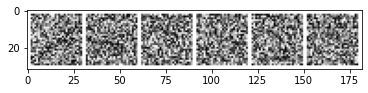

The Bayesian classifier could assess 89% of the random images with certainty, mostly as a Sneaker


In [6]:
from torch import rand, empty, zeros
from matplotlib import pyplot

# Uniformly random images
images = rand(1000, 1, 28, 28)

# Calculate uncertainty of the network on random images
certainty, accuracy = bayesianCNN.uncertaintyAccuracy([(images, empty(1000))])

# Calculate the most selected class for random images
res = zeros(10)
predicted = bayesianCNN(images).argmax(1)
for _, l in enumerate(predicted):
    res[l - 1] += 1

# Show some random images
img = utils.make_grid(images[0 : 6])
pyplot.imshow((1 - img).numpy().transpose((1, 2, 0)))
pyplot.show()

print('The Bayesian classifier could assess %d%% of the random images with certainty, mostly as a %s' % 
    (certainty * 100, classes[res.argmax()]))